### set data

In [1]:
df = pd.read_csv("../data/edited.csv", skiprows=lambda i: i % 100 != 0)
# 100분의 1 데이터만 사용합니다. 속도를 위해...

y = df['is_attributed']
X = df.drop('is_attributed', axis=1)
del df

In [2]:
from sklearn.model_selection import train_test_split
'''
모델의 성능을 평가하기 위한  데이터를 따로 나눠둡니다.
학습은 물론 샘플링도 적용하지 않습니다.

학습에는 X_train, y_train만 사용합니다.
    성능평가에는 X_test, y_test를 사용합니다.

학습에 사용한 데이터로 평가를 진행한다면...?
    모의고사에 나온 문제가 수능에 "똑같이" 나오는 상황과 같겠죠.
'''
X_train, X_test = train_test_split(X, test_size = .2, random_state=0)
y_train, y_test = train_test_split(y, test_size = .2, random_state=0)

del X, y

최종 모델을 만들 때는 self test set을 나누지 않을 수도 있습니다.

### under sampling

In [3]:
from imblearn.under_sampling import RandomUnderSampler
'''
비대칭 문제를 해결하기 위해 샘플링을 합니다.

여기서는 undersamplilng을 진행합니다.
'''

X0, y0 = RandomUnderSampler(random_state=31).fit_sample(X_train, y_train)

X_train = pd.DataFrame(data=X0, columns=X_train.columns)
y_train = pd.Series(y0, name='is_attributed')
del X0, y0

지금은 전체 데이터에 대해 언더샘플링을 했지만,
샘플링은 다양한 방식으로 시도할 수 있습니다. 

- 데이터마다 가장 잘 맞는 방식이 다릅니다.
- 저는 실제 경연에서는 train의 일부를 샘플링 하지 않고 validation set(test_data)으로 사용했습니다.
- 더 나은 샘플링 방식, 혹은 관련 논문에 대해 알고 계신 분은 공유 부탁드립니다 :D

In [4]:
import lightgbm as lgb
'''
lightgbm은 train set과 validation set(test set)으로 나누어 학습을 시켜야합니다.

Dataset을 이용하면 lgb가 요구하는 데이터형식으로 변환이 가능합니다.
'''

X_train, X0_test = train_test_split(X_train, test_size = .25, random_state=0)
y_train, y0_test = train_test_split(y_train, test_size = .25, random_state=0)

train_data = lgb.Dataset(X_train, label=y_train, 
                         categorical_feature=['ip', 'app', 'device', 'os', 'channel', 'hour']
                        )
test_data = lgb.Dataset(X0_test, label=y0_test,
                         categorical_feature=['ip', 'app', 'device', 'os', 'channel', 'hour']
                       )

# 테스트로 사용할 데이터도 Dataset 형식으로 바꿔줍니다.
self_test_data = lgb.Dataset(X_test, label=y_test,
                             categorical_feature=['ip', 'app', 'device', 'os', 'channel', 'hour']
                       )

In [5]:
param = {
        'objective': 'binary', 
         # 1 과 0 을 구분하는 문제니까 binary! 
      
        'boosting':'goss', 
         # Gradient-based One-Side Sampling 
         # 일반적인 의사결정나무 부스팅(gbdt)보다 빠른 수렴이 가능합니다.
         # 하지만 과최적화에 빠지기 더 쉽습니다.  
    
        'num_leaves':20, 'max_depth':5,
         # boosting의 기본이 되는 의사결정나무의 각 노드(leave)와 깊이(depth) 제한입니다.
         # 따로 설정해주지 않으면 과최적화에 빠지기 쉽습니다.
         # 공식 문서에서 권장하는 기준은 num_leaves =< max_depth**2 입니다.
         
         'min_data_in_leaf':10,
         # 말그대로 의사결정나무의 노드 하나에 포함된 최소한의 데이터 갯수입니다.
         # 과최적화를 방지하기 위해 설정합니다.

        'metric':'auc', 
         # score 평가 방식은 auc였습니다. 
        }

evals_result0={} 
# 학습상태를 저장하기 위한 변수입니다.

num_round = 500 
# 반복 횟수입니다.

parameter 설정에 대한 더 
자세한 설명은 공식 문서를 참고하실 수 있습니다.

- parameter가 굉장히 많습니다.

https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst

### 드디어 학습!

In [6]:
bst = lgb.train(param, train_data, num_round, valid_sets=[test_data], evals_result=evals_result0, 
                
                early_stopping_rounds=20, 
                # N번의 반복동안 점수가 높아지지 않으면 학습을 중단합니다.
                # 최적점에 도달했거나, local optima에 빠졌을 수 있습니다. 
                
                verbose_eval=20, 
                # N번의 round마다 학습 결과를 표시합니다.
                
                categorical_feature=['ip', 'app', 'device', 'os', 'channel', 'hour'],
                )

Training until validation scores don't improve for 20 rounds.
[20]	valid_0's auc: 0.961743
[40]	valid_0's auc: 0.964339
[60]	valid_0's auc: 0.965572
Early stopping, best iteration is:
[59]	valid_0's auc: 0.965842


/home/mk/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


In [7]:
# 학습시킨모델을 save 해둡니다.
bst.save_model('../data/model_test.txt', num_iteration=bst.best_iteration)

#### 따로 분리해두었던 self_test_data 로 Crossvalidation을 합니다.
- 과최적화가 되지 않았다면, 학습 결과와 비슷한 점수가 나올 것입니다.

In [8]:
cv_result = lgb.cv(param, self_test_data, num_boost_round=num_round, nfold=3, verbose_eval=50, early_stopping_rounds=20)

/home/mk/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/mk/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[50]	cv_agg's auc: 0.93151 + 0.00399002
[100]	cv_agg's auc: 0.960382 + 0.00542216


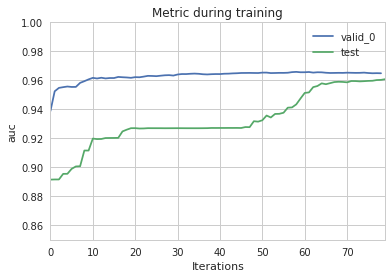

In [9]:
%matplotlib inline
lgb.plot_metric(evals_result0, metric='auc', )
plt.plot(cv_result['auc-mean'], label = 'test')
plt.legend()
plt.ylim(0.85, 1)
plt.show()

다소 과최적화되었나..싶다가 급격히 따라잡았네요. 점수는 살짝 아쉽습니다.
- 파라미터 최적화를 진행하면 더 나은 성능을 기대할 수 있습니다.
- 전체 데이터를 쓰고, 샘플링도 다른 방식으로 시도해볼 수 있습니다.

### plot_importance 함수를 이용해서 각 변수의 중요도를 확인할 수 있습니다.
import_type에 따라 중요도의 기준이 달라집니다.
- split : 모델에 변수가 쓰인 `횟수`가 기준이 됩니다.
- gain : 모델에 변수가 준 `정보량`이 기준이 됩니다.

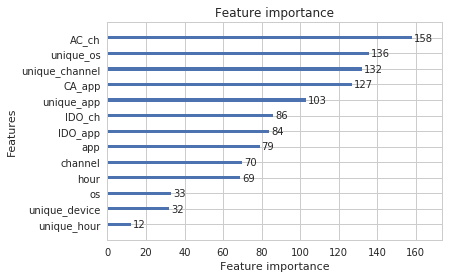

In [10]:
ax = lgb.plot_importance(bst, importance_type='split')
plt.show()

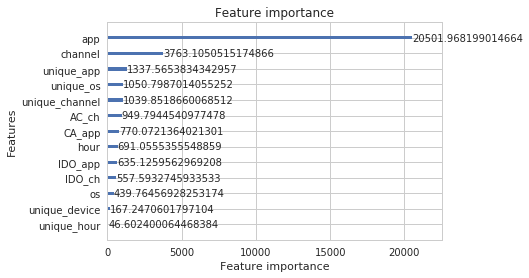

In [11]:
ax = lgb.plot_importance(bst, importance_type='gain')
plt.show()

생각보다 변수가 골고루 쓰이지는 않았네요... 아쉽
- 아마 parameter를 조정하면 달라지겠죠? bagging 이라던지... 

### 이번에는 Test 데이터로 predict 해서 뭘 얼마나 맞혔고 틀렸는지 확인해봅니다.

In [12]:
from sklearn.metrics import *
from sklearn.model_selection import *

y_pred = bst.predict(X_test,  num_iteration=bst.best_iteration)

target_names=['0', '1'] # 0 : 앱 미구매, 1 : 앱 구매

a = list(map(lambda x: 1 if x >0.5 else 0,  y_pred))

print("roc_auc : ",roc_auc_score(y_test[:], y_pred))
print("\n",confusion_matrix(y_test, a))
print(classification_report(y_test, a, target_names=target_names))

roc_auc :  0.9647998747469481

 [[351904  16984]
 [   121    799]]
             precision    recall  f1-score   support

          0       1.00      0.95      0.98    368888
          1       0.04      0.87      0.09       920

avg / total       1.00      0.95      0.97    369808



In [13]:
a = list(map(lambda x: 1 if x >0.1 else 0,  y_pred))

print("roc_auc : ",roc_auc_score(y_test[:], y_pred))
print("\n",confusion_matrix(y_test, a))
print(classification_report(y_test, a, target_names=target_names))

roc_auc :  0.9647998747469481

 [[230025 138863]
 [    25    895]]
             precision    recall  f1-score   support

          0       1.00      0.62      0.77    368888
          1       0.01      0.97      0.01       920

avg / total       1.00      0.62      0.77    369808



### 1. threshold를 낮게 하면 

클래스 1의 recall이 올라가지만, 그만큼 클래스 0의 recall이 낮아지는 걸 볼 수 있습니다.
1. 앱 구매한 고객을 더 추려내려고 하면 (recall을 높게하려면), 
1. 조금의 확률만 있어도 구매했다고 예측할 것이고, 
1. 구매하지 않은 고객을 구매한 고객으로 잘못 추려낼 확률(fall-out)이 높아지겠죠? 
1. 동시에 클래스 1의 precision, 정확도도 낮아지게 됩니다.


- Precision:
    
    예측한 값이 맞은 비율입니다. 정확도라고 볼 수 있습니다.

    $$ \text{Precision} = \dfrac{TP}{TP+FP}$$

### 2. ROC_AUC 점수는 
1. 이 모든 threshold값이 변화하면서
1. 함께 바뀌는  Recall-Fallout 변화량 곡선의 아랫부분 면적을 나타낸 것이기 때문에
1. threshold값을 바꾼다해도 점수는 같습니다.

아래는 Logistic Regression모델을 사용해서 그린 ROC Curve와 PR Curve입니다.

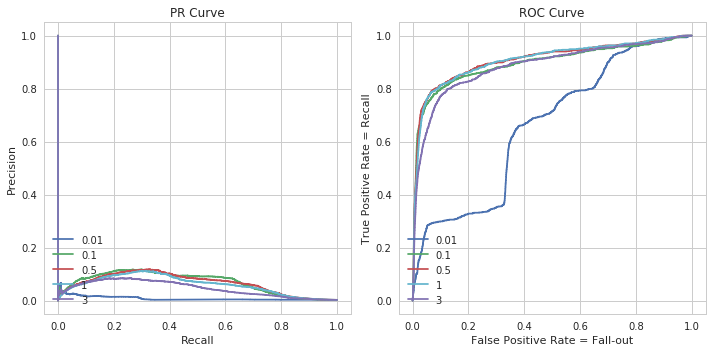

In [14]:
from sklearn.linear_model import LogisticRegression

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate = Fall-out')
ax2.set_ylabel('True Positive Rate = Recall')
ax2.set_title('ROC Curve')

for w,k in zip([0.01, 0.1, 0.5, 1, 3],'bgrcmykw'):
    lr_model = LogisticRegression(class_weight={0:1,1:w})
    lr_model.fit(X_train,y_train)
    pred_prob = lr_model.predict_proba(X_test)[:,1]

    p,r,_ = precision_recall_curve(y_test,pred_prob)
    tpr,fpr,_ = roc_curve(y_test,pred_prob)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)
    
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')
plt.tight_layout()
plt.show()

이번 평가방식은 AUC_ROC 방식이지만, 경우에 따라 PR 커브를 더 중요시하는 경우도 있습니다.
- PR커브는 Precision과 Recall의 비율로 표현합니다.

---